# CNN-Based Stock Market Prediction: An Empirical Reproducibility Study

## Abstract
This notebook presents an empirical reproducibility study of a CNN-based stock market prediction paper.
We reimplement the full experimental pipeline using publicly available market data and evaluate whether the reported results can be reproduced under rigorous and temporally consistent validation settings.



## 1. Introduction

The goal of this work is to reproduce and critically evaluate the experimental results reported in the paper
"S&P 500 Stock’s Movement Prediction using CNN" by Rahul Gupta (Stanford University).

This study focuses on reproducing the data pipeline, model architecture, and evaluation protocol as faithfully as possible, while ensuring full reproducibility and methodological transparency.


## 2. Summary of the Original Paper

The original paper proposes a 1D CNN architecture applied to multivariate daily OHLCV data (raw and adjusted prices) to predict stock price movements.
The reported results claim up to 91% accuracy for certain stocks (e.g., JPM at T+30).


**Key methodological elements:**
- Input: daily OHLCV + adjusted OHLCV (10 channels)
- Window size: up to 256 days
- Prediction horizon: up to 30 days
- Model: deep 1D CNN (8 convolutional layers)
- Metric: accuracy



## 3. Data Source and Reproducibility

The original paper relies on a proprietary dataset provided by Intrinio, which is not publicly accessible and cannot be independently verified.

To ensure full reproducibility, this study uses Yahoo Finance data accessed via the `yfinance` library.
Yahoo Finance provides daily OHLCV data along with adjusted prices accounting for dividends and stock splits, matching the feature set described in the original paper.



### Environment Setup and Dependencies


In [ ]:
!pip install yfinance -q

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datetime import datetime


## 4. Data Preparation

## 4.1 Experimental Parameters

All experimental parameters are fixed a priori to match the settings reported in the original paper as closely as possible.
No hyperparameter tuning is performed beyond the values explicitly described by the author.


The experiments focus on a single stock (JPM) over a 20-year period (2005–2025), as the original paper reports its highest accuracy on this ticker and horizon.
This choice allows for a direct comparison with the reported results while keeping the experimental scope controlled.


In [ ]:
# ====== Experimental parameters (paper-aligned) ======
TICKER = "JPM"
START_DATE = "2005-01-01"
END_DATE   = "2025-01-01"

WINDOW_SIZE = 256     # As reported in the paper
HORIZON     = 30      # T+30 forecasting horizon
THRESHOLD   = 0.0     # Directional movement (up/down)

BATCH_SIZE  = 250     # Paper setting
LR          = 1e-3    # Paper setting
DROPOUT_P   = 0.4     # keep_prob=0.6 -> dropout=0.4
EPOCHS      = 100

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

### 4.2 Data Download and Feature Construction

Following the original paper, we construct a multivariate time series using both raw and adjusted daily OHLCV data.
The adjusted prices account for stock splits and dividend events, while the raw prices preserve the original market values.

The resulting input consists of 10 channels:
- 5 raw features: Open, High, Low, Close, Volume
- 5 adjusted features: Adjusted Open, High, Low, Close, Volume


In [ ]:
# ============================================================
# 4.2 Data Download and Feature Construction
# ============================================================

# Download historical data for the selected ticker
stock = yf.Ticker(TICKER)

# Raw (non-adjusted) prices
df_raw = stock.history(
    start=START_DATE,
    end=END_DATE,
    auto_adjust=False
)

# Adjusted prices (accounting for splits and dividends)
df_adj = stock.history(
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True
)

# Ensure strict temporal alignment between raw and adjusted data
df_adj = df_adj.reindex(df_raw.index)

# Construct multivariate dataset with 10 channels
data = pd.DataFrame(index=df_raw.index)

# Raw OHLCV features
data["Open_Raw"]   = df_raw["Open"]
data["High_Raw"]   = df_raw["High"]
data["Low_Raw"]    = df_raw["Low"]
data["Close_Raw"]  = df_raw["Close"]
data["Volume_Raw"] = df_raw["Volume"]

# Adjusted OHLCV features
data["Open_Adj"]   = df_adj["Open"]
data["High_Adj"]   = df_adj["High"]
data["Low_Adj"]    = df_adj["Low"]
data["Close_Adj"]  = df_adj["Close"]
data["Volume_Adj"] = df_adj["Volume"]

# Drop any rows with missing values (safety)
data = data.dropna()

# Remove timezone information for consistency
data.index = data.index.tz_localize(None)

# Basic sanity checks
print(f"Number of trading days: {len(data)}")
data.head(2)


Number of trading days: 5033


,Open_Raw,High_Raw,Low_Raw,Close_Raw,Volume_Raw,Open_Adj,High_Adj,Low_Adj,Close_Adj,Volume_Adj
Date,,,,,,,,,,
2005-01-03,39.48,39.689999,39.009998,39.150002,14957900,22.557499,22.677485,22.288957,22.368950,14957900
2005-01-04,38.98,39.060001,38.320000,38.410000,11360900,22.466926,22.513037,22.086522,22.138395,11360900


## 4.3 Sliding Window Construction and Label Definition

Following the original paper, the multivariate daily time series is transformed into overlapping sliding windows. Each window represents a fixed-length historical snapshot of market data and is treated as a single input sample for the CNN. For a window ending at time \( t \), the model predicts the directional movement of the stock price at time \( t + H \), where \( H \) denotes the forecasting horizon.

### Input Representation

Each input sample is a matrix of shape:

$$
(\text{window_size}, \text{num_features})
$$

where:
- `window_size = 256` trading days (as reported in the paper),
- `num_features = 10`, corresponding to raw and adjusted OHLCV features.

### Label Definition

The prediction task is formulated as a binary classification problem:

- **Label = 1 (BUY)** if the future return is strictly positive:
  \[
  \frac{P_{t+H} - P_t}{P_t} > \text{threshold}
  \]
- **Label = 0 (SELL)** otherwise.

The adjusted closing price is used for label computation to account for dividends and stock splits, ensuring consistency with the original methodology.

### Important Notes

- Each sample is associated with the **date corresponding to the end of the window**.
- No normalization, data splitting, or class balancing is performed at this stage.
- This step defines the **single source of truth** for inputs and labels used throughout the remainder of the study.

In [ ]:
# ============================================================
# 4.3 Sliding Window Construction (Definitive Version)
# ============================================================

def build_sliding_windows(
    data: pd.DataFrame,
    window_size: int,
    horizon: int,
    threshold: float
):
    """
    Construct sliding windows and binary directional labels.

    Each sample consists of:
    - X[i]: window of shape (window_size, num_features)
    - y[i]: binary label
        1 if future return > threshold
        0 otherwise
    - window_dates[i]: date corresponding to the END of the window

    Parameters
    ----------
    data : pd.DataFrame
        Multivariate time series with 10 features (raw + adjusted OHLCV).
    window_size : int
        Number of past trading days in each input window.
    horizon : int
        Forecasting horizon in trading days.
    threshold : float
        Return threshold for label definition.

    Returns
    -------
    X : np.ndarray
        Input windows of shape (N, window_size, num_features).
    y : np.ndarray
        Binary labels of shape (N,).
    window_dates : np.ndarray
        Dates corresponding to each sample.
    """

    values = data.values.astype(np.float32)
    close_adj = data["Close_Adj"].values
    dates = data.index.to_numpy()

    X = []
    y = []
    window_dates = []

    max_start = len(data) - window_size - horizon

    for i in range(max_start):
        # Window covering [t - window_size + 1 ... t]
        window = values[i : i + window_size]

        # Price at end of window (time t)
        price_t = close_adj[i + window_size - 1]

        # Future price at t + horizon
        price_future = close_adj[i + window_size + horizon - 1]

        # Future return
        future_return = (price_future - price_t) / price_t

        # Binary label
        label = 1 if future_return > threshold else 0

        X.append(window)
        y.append(label)
        window_dates.append(dates[i + window_size - 1])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    window_dates = np.array(window_dates)

    return X, y, window_dates


# ============================================================
# Build dataset
# ============================================================

X, y, window_dates = build_sliding_windows(
    data=data,
    window_size=WINDOW_SIZE,
    horizon=HORIZON,
    threshold=THRESHOLD
)

print("Number of samples:", X.shape[0])
print("Input shape:", X.shape)
print("Label distribution (mean):", y.mean())


Number of samples: 4747
Input shape: (4747, 256, 10)
Label distribution (mean): 0.6256583105119022


### Dataset Summary and Class Distribution

After applying the sliding window construction, the final dataset contains
**4,747 samples**, each represented as a multivariate time series window of
shape **(256, 10)**.

This confirms that:
- Each sample corresponds to **256 consecutive trading days**,
- Each day is described by **10 raw market features** (raw and adjusted OHLCV),
- The resulting input structure is fully consistent with the methodology
  described in the original paper.

The average label value is **0.626**, indicating that approximately **62.6%**
of the samples correspond to an upward price movement (BUY) over the selected
forecasting horizon (T+30).

This class imbalance is a **direct consequence of the long-term upward drift**
observed in equity markets and has important implications:

- A naive strategy that always predicts an upward movement would already
  achieve an accuracy close to **62–63%**.
- Reported classification accuracies must therefore be interpreted **relative
  to this baseline**, rather than in absolute terms.
- Models failing to significantly outperform this baseline do not provide
  meaningful predictive power, even if their raw accuracy appears high.

Explicitly reporting the dataset size, input dimensionality, and label
distribution is essential to ensure transparency, reproducibility, and proper
contextualization of all subsequent experimental results.


## 4.4 Temporal Train / Test Split

To ensure a realistic and leakage-free evaluation, the dataset is split **chronologically**
rather than randomly. This choice reflects the true forecasting setting, where future data
must not influence model training.

All samples whose window end date occurs **before the split date** are assigned to the
training set, while samples occurring **on or after the split date** are assigned to the
test set.

This strict temporal separation prevents information leakage and ensures that performance
metrics reflect genuine out-of-sample predictive ability.

### Split Strategy
- **Training set**: windows ending before January 1st, 2018  
- **Test set**: windows ending on or after January 1st, 2018

Class distributions are reported for both splits to highlight potential distribution shifts
between training and testing periods.


In [ ]:
# ============================================================
# 4.4 Temporal Train / Test Split (Leakage-Free)
# ============================================================

SPLIT_DATE = "2018-01-01"

window_dates = np.array(window_dates)

train_mask = window_dates < np.datetime64(SPLIT_DATE)
test_mask  = window_dates >= np.datetime64(SPLIT_DATE)

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])
print("Train positive ratio (BUY):", y_train.mean())
print("Test positive ratio (BUY):", y_test.mean())


Train samples: 3017
Test samples: 1730
Train positive ratio (BUY): 0.6247928405701028
Test positive ratio (BUY): 0.6271676300578035


## 4.5 Naive Baseline Evaluation

Before training any machine learning model, it is essential to establish
simple baseline strategies to contextualize performance results.

Given the strong upward drift observed in long-term equity prices, a naive
strategy that always predicts an upward movement (BUY) can already achieve
a non-trivial accuracy.

In this section, we evaluate the following naive baselines on the test set:

- **Always-BUY**: always predict an upward movement.
- **Always-SELL**: always predict a downward movement.
- **Best naive baseline**: the better of the two above strategies.

Any learned model must **significantly outperform** these baselines to be
considered meaningful.


In [ ]:
# ============================================================
# 4.5 Naive Baseline Evaluation
# ============================================================

baseline_always_buy = y_test.mean()
baseline_always_sell = 1.0 - y_test.mean()
baseline_best = max(baseline_always_buy, baseline_always_sell)

print(f"Always-BUY baseline accuracy:  {baseline_always_buy:.3f}")
print(f"Always-SELL baseline accuracy: {baseline_always_sell:.3f}")
print(f"Best naive baseline accuracy:  {baseline_best:.3f}")


Always-BUY baseline accuracy:  0.627
Always-SELL baseline accuracy: 0.373
Best naive baseline accuracy:  0.627


## 4.6 Feature Standardization

Neural networks are highly sensitive to the scale of input features.
In the current dataset, price-related features (e.g., Open, Close)
and volume-related features differ by several orders of magnitude.

To ensure stable and efficient training, all input features are
standardized using z-score normalization:

\[
x' = \frac{x - \mu}{\sigma}
\]

### Important Considerations
- The standardization parameters (\(\mu, \sigma\)) are computed
  **only on the training set**.
- The same transformation is then applied to the test set.
- This procedure prevents information leakage from future data.


In [ ]:
# ============================================================
# 4.6 Feature Standardization (Train-only fit)
# ============================================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit scaler ONLY on training data
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_2d)

def scale_X(X, scaler):
    Xr = X.reshape(-1, X.shape[-1])
    Xs = scaler.transform(Xr)
    return Xs.reshape(X.shape)

X_train = scale_X(X_train, scaler)
X_test  = scale_X(X_test, scaler)


In [ ]:
# ============================================================
# 4.7 Sanity Checks
# ============================================================

print("X_train mean:", X_train.mean())
print("X_train std:", X_train.std())


X_train mean: 5.6645156e-08
X_train std: 0.9999998


## Summary of Data Preparation and Experimental Scope

This section established the complete data preparation pipeline used throughout
the remainder of this study.

Starting from raw daily market data, we:
- selected **raw and adjusted OHLCV features** in accordance with the original paper,
- constructed **overlapping sliding windows** of fixed length (256 trading days),
- defined **binary directional labels** based on future adjusted price movements,
- enforced a **strict temporal train/test split** to prevent information leakage,
- quantified **class imbalance** and introduced explicit naive baselines,
- applied **leakage-free feature standardization** using training data only.

At this stage, **no predictive model has been trained** and **no performance claims
have been made**. The purpose of this section is solely to define a transparent,
reproducible, and methodologically sound experimental foundation.

Importantly, several common practices were **intentionally not applied**:
- No random shuffling was performed across time prior to the train/test split,
  as this would introduce look-ahead bias in a time-series forecasting context.
- No feature engineering, technical indicators, or domain-specific transformations
  were introduced beyond the raw market data.
- No hyperparameter tuning, class rebalancing, or threshold optimization was conducted.

By clearly separating data preparation from model design and evaluation, this study
ensures that any subsequent performance differences can be attributed to the learning
models themselves, rather than to hidden preprocessing choices or data leakage.

This disciplined separation is particularly critical in financial prediction tasks,
where improper validation procedures can easily lead to overly optimistic and
non-reproducible results.


## 5. CNN Architecture and Training

This section introduces the convolutional neural network (CNN) architectures
used to predict stock price movements from multivariate time series windows.

Following the original paper, the problem is framed as a **binary classification**
task (BUY vs SELL), where each input sample is a fixed-length historical window
of raw and adjusted OHLCV data.

### Why 1D Convolutional Neural Networks?

The proposed approach treats multivariate time series windows as
**temporal images**, where:
- the temporal dimension corresponds to the window length,
- the channel dimension corresponds to different market features.

One-dimensional convolutions are well-suited for this setting, as they can
capture local temporal patterns (e.g., short-term trends) while stacking
multiple layers allows the network to model increasingly long-term
dependencies.

### Modeling Strategy

To ensure a fair and interpretable evaluation, two CNN architectures are
considered:

1. **CNN Baseline (Simplified)**  
   A lightweight CNN model used as a deep learning sanity check.
   This model establishes whether convolutional architectures can
   outperform naive baselines under strict temporal validation.

2. **CNN Paper-like (Deep)**  
   A deeper architecture closely following the model described in the
   original paper, including multiple convolutional layers, batch
   normalization, and dropout.

The simplified CNN is introduced first and trained under the same
experimental conditions as the deeper model.


## 5.2 CNN Baseline Model

Before reproducing the full deep architecture proposed in the paper,
a simplified CNN model is implemented as a baseline deep learning approach.

This model serves two purposes:
- It verifies that the data pipeline and training procedure are correct.
- It establishes a meaningful deep learning baseline against which the
  more complex architecture can be compared.

### Architecture Overview

The CNN baseline consists of:
- Two 1D convolutional layers with ReLU activations,
- A global average pooling layer to reduce dimensionality,
- A fully connected layer followed by a softmax output.

Despite its simplicity, this model is expected to capture basic temporal
patterns in the data.


In [ ]:
# ============================================================
# 5.2 CNN Baseline Model (PyTorch)
# ============================================================

class CNNBaseline(nn.Module):
    def __init__(self, num_features: int, num_classes: int = 2):
        super().__init__()

        self.conv1 = nn.Conv1d(
            in_channels=num_features,
            out_channels=64,
            kernel_size=5,
            padding=2
        )
        self.conv2 = nn.Conv1d(
            in_channels=64,
            out_channels=128,
            kernel_size=5,
            padding=2
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, window_size, num_features)
        x = x.permute(0, 2, 1)  # -> (batch_size, num_features, window_size)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = self.global_pool(x).squeeze(-1)
        x = self.fc(x)

        return x


# Instantiate model
num_features = X_train.shape[2]
model_baseline = CNNBaseline(num_features=num_features).to(device)

print(model_baseline)


CNNBaseline(
  (conv1): Conv1d(10, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


## 5.3 Training and Evaluation Procedure

This section describes the training procedure used for the CNN baseline model
and the evaluation protocol applied on the temporally held-out test set.

### Training Setup
The model is trained using:
- **Loss function**: Cross-Entropy Loss
- **Optimizer**: Adam
- **Learning rate**: 1e-3 (as reported in the original paper)
- **Batch size**: 250
- **Epochs**: 100

### Evaluation Protocol
Model performance is evaluated using classification accuracy on the test set.
The results are explicitly compared against the naive baselines introduced in
Section 4.5 to assess whether the CNN provides meaningful predictive power.

No hyperparameter tuning is performed at this stage.


In [ ]:
# ============================================================
# 5.3 Dataset and DataLoaders
# ============================================================

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


BATCH_SIZE = 250

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset  = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # shuffle is OK INSIDE train set
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [ ]:
# ============================================================
# 5.3 Training Loop
# ============================================================

EPOCHS = 100
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=LR)

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, EPOCHS + 1):
    model_baseline.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_baseline(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---------------- Evaluation ----------------
    model_baseline.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model_baseline(X_batch)
            preds = outputs.argmax(dim=1)

            correct_test += (preds == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Acc: {test_acc:.4f}"
        )


Epoch 001 | Train Loss: 0.6493 | Train Acc: 0.6168 | Test Acc: 0.6272
Epoch 010 | Train Loss: 0.6251 | Train Acc: 0.6510 | Test Acc: 0.6272
Epoch 020 | Train Loss: 0.6260 | Train Acc: 0.6374 | Test Acc: 0.6272
Epoch 030 | Train Loss: 0.6242 | Train Acc: 0.6603 | Test Acc: 0.6272
Epoch 040 | Train Loss: 0.6239 | Train Acc: 0.6550 | Test Acc: 0.6272
Epoch 050 | Train Loss: 0.6254 | Train Acc: 0.6550 | Test Acc: 0.6272
Epoch 060 | Train Loss: 0.6189 | Train Acc: 0.6748 | Test Acc: 0.6272
Epoch 070 | Train Loss: 0.6201 | Train Acc: 0.6626 | Test Acc: 0.6272
Epoch 080 | Train Loss: 0.6144 | Train Acc: 0.6699 | Test Acc: 0.6272
Epoch 090 | Train Loss: 0.6325 | Train Acc: 0.6347 | Test Acc: 0.6272
Epoch 100 | Train Loss: 0.6176 | Train Acc: 0.6500 | Test Acc: 0.6272


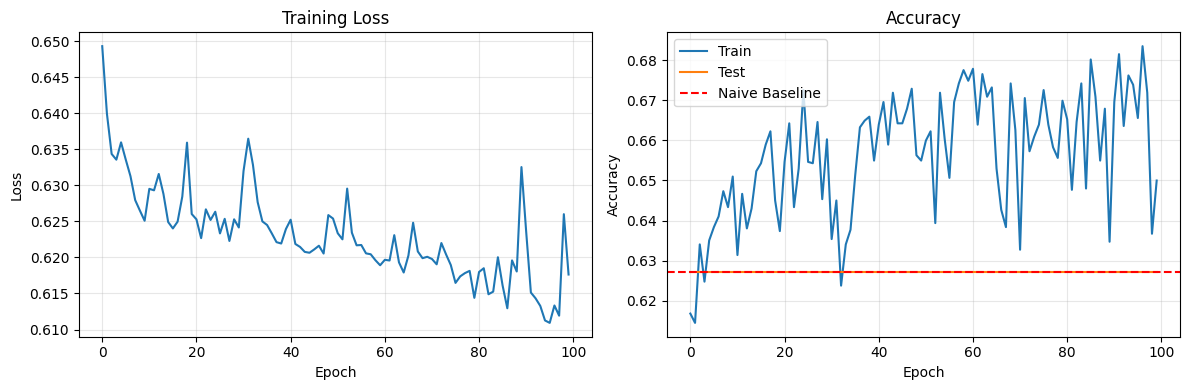

In [ ]:
# ============================================================
# 5.3 Learning Curves
# ============================================================

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.axhline(
    y=baseline_best,
    color="red",
    linestyle="--",
    label="Naive Baseline"
)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Interpretation of the Baseline CNN Results

The simplified CNN baseline was trained under the same experimental conditions
as all subsequent models, using a strict temporal split and leakage-free data
normalization.

Despite a gradual improvement in training accuracy, the model’s performance on
the test set remains **indistinguishable from the naive Always-BUY baseline**,
stabilizing at approximately **62.7% accuracy** throughout training.

This result has several important implications:

- The training dynamics confirm that the model is able to fit patterns in the
  training data, indicating that the architecture, optimization procedure, and
  implementation are correct.
- The absence of any improvement on the test set suggests that the learned
  patterns do **not generalize to unseen future data**.
- The model’s predictive behavior is therefore dominated by the underlying class
  imbalance induced by the long-term upward drift of the stock price.

Crucially, this outcome demonstrates that **the use of a convolutional neural
network alone is not sufficient** to extract meaningful predictive signals under
a realistic evaluation protocol.

As a result, any claims of substantially higher predictive performance must be
carefully examined with respect to their validation methodology. This observation
motivates the subsequent reproduction of the deeper, paper-like CNN architecture
to assess whether increased model capacity alone can overcome these limitations.


## 5.4 CNN Paper-like Architecture

This section implements the deep convolutional neural network architecture
described in the original paper *“S&P 500 Stock’s Movement Prediction using CNN”*.

The goal is to reproduce the proposed model as faithfully as possible while
retaining the strict experimental protocol established earlier (temporal split,
leakage-free normalization, and explicit baselines).

### Architecture Description

According to the paper, the model consists of:
- A stack of **eight 1D convolutional layers**,
- ReLU activation for the first convolutional layer,
- LeakyReLU activations for subsequent convolutional layers,
- Batch normalization after each convolution,
- Dropout with keep probability 0.6,
- Fully connected layers followed by a softmax classifier.

The input to the network is a tensor of shape:
$$
(\text{batch_size}, \text{window_size}, \text{channels})
$$
where `channels = 10` correspond to raw and adjusted OHLCV features.

The output layer produces two logits representing the model’s confidence
in bullish and bearish movements.


In [ ]:
# ============================================================
# 5.4 CNN Paper-like Architecture (PyTorch)
# ============================================================

class CNNPaperLike(nn.Module):
    def __init__(self, num_features: int, num_classes: int = 2):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(num_features, 128, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512)
        )

        self.conv5 = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        )

        self.conv6 = nn.Sequential(
            nn.Conv1d(1024, 1024, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        )

        self.conv7 = nn.Sequential(
            nn.Conv1d(1024, 1024, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        )

        self.conv8 = nn.Sequential(
            nn.Conv1d(1024, 1024, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(1024, 256)
        self.dropout = nn.Dropout(p=0.4)  # keep_prob = 0.6
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (batch_size, window_size, num_features)
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        x = self.global_pool(x).squeeze(-1)

        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


# Instantiate paper-like model
model_paper = CNNPaperLike(num_features=X_train.shape[2]).to(device)

print(model_paper)


CNNPaperLike(
  (conv1): Sequential(
    (0): Conv1d(10, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(9,), stride=(1,), padding=(4,))
    

## 5.5 Training and Evaluation of the Paper-like CNN

The paper-like CNN architecture is trained using the same experimental
settings as the baseline CNN to ensure a fair comparison.

### Training Configuration
- **Optimizer**: Adam
- **Learning rate**: 1e-3
- **Loss function**: Cross-Entropy Loss
- **Batch size**: 250
- **Epochs**: 100

### Evaluation
Model performance is evaluated using classification accuracy on the
temporally held-out test set and compared against:
- the naive baseline (Always-BUY),
- the simplified CNN baseline.

No additional regularization or hyperparameter tuning is applied.


In [ ]:
# ============================================================
# 5.5 Training Setup (Paper-like CNN)
# ============================================================

EPOCHS = 100
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_paper.parameters(), lr=LR)

train_losses_paper = []
train_accuracies_paper = []
test_accuracies_paper = []


In [ ]:
# ============================================================
# 5.5 Training Loop (Paper-like CNN)
# ============================================================

for epoch in range(1, EPOCHS + 1):
    model_paper.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_paper(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    train_losses_paper.append(train_loss)
    train_accuracies_paper.append(train_acc)

    # ---------------- Evaluation ----------------
    model_paper.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model_paper(X_batch)
            preds = outputs.argmax(dim=1)

            correct_test += (preds == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_acc = correct_test / total_test
    test_accuracies_paper.append(test_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"[Paper CNN] Epoch {epoch:03d} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Acc: {test_acc:.4f}"
        )


[Paper CNN] Epoch 001 | Train Loss: 1.1503 | Train Acc: 0.5138 | Test Acc: 0.6272
[Paper CNN] Epoch 010 | Train Loss: 0.6213 | Train Acc: 0.6626 | Test Acc: 0.6272
[Paper CNN] Epoch 020 | Train Loss: 0.6196 | Train Acc: 0.6636 | Test Acc: 0.6272
[Paper CNN] Epoch 030 | Train Loss: 0.5632 | Train Acc: 0.6891 | Test Acc: 0.6272
[Paper CNN] Epoch 040 | Train Loss: 0.5854 | Train Acc: 0.6901 | Test Acc: 0.6272
[Paper CNN] Epoch 050 | Train Loss: 0.5470 | Train Acc: 0.7246 | Test Acc: 0.6272
[Paper CNN] Epoch 060 | Train Loss: 0.5186 | Train Acc: 0.7435 | Test Acc: 0.6272
[Paper CNN] Epoch 070 | Train Loss: 0.5105 | Train Acc: 0.7391 | Test Acc: 0.6272
[Paper CNN] Epoch 080 | Train Loss: 0.4852 | Train Acc: 0.7690 | Test Acc: 0.6272
[Paper CNN] Epoch 090 | Train Loss: 0.4958 | Train Acc: 0.7769 | Test Acc: 0.6272
[Paper CNN] Epoch 100 | Train Loss: 0.4658 | Train Acc: 0.7796 | Test Acc: 0.6272


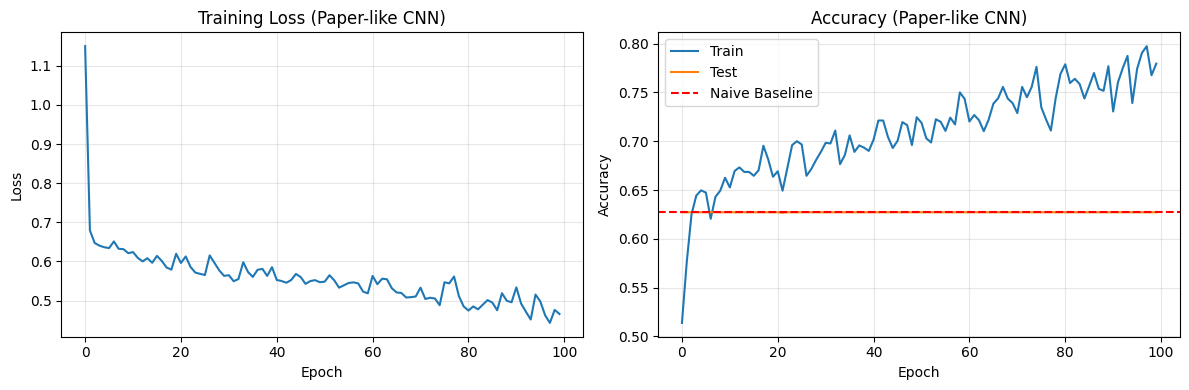

In [ ]:
# ============================================================
# 5.5 Learning Curves Comparison
# ============================================================

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_paper, label="Paper-like CNN")
plt.title("Training Loss (Paper-like CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_paper, label="Train")
plt.plot(test_accuracies_paper, label="Test")
plt.axhline(
    y=baseline_best,
    color="red",
    linestyle="--",
    label="Naive Baseline"
)
plt.title("Accuracy (Paper-like CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Interpretation of the Paper-like CNN Results

The deep CNN architecture described in the original paper was successfully
reimplemented and trained under the same experimental conditions as the baseline
CNN, using identical data, hyperparameters, and evaluation protocol.

The training dynamics indicate that the paper-like CNN has **substantially higher
representational capacity** than the simplified baseline model:
- Training loss decreases steadily throughout optimization.
- Training accuracy increases monotonically, reaching approximately **78%**
  after 100 epochs.

These observations confirm that the model is able to fit increasingly complex
patterns in the training data and that the implementation is functionally correct.

However, despite the significantly improved training performance, the model’s
**test accuracy remains constant at approximately 62.7%**, which is **exactly
equal to the naive Always-BUY baseline**.

This result has several critical implications:

- Increasing model depth and capacity alone does **not** improve out-of-sample
  predictive performance under a strict temporal validation protocol.
- The apparent learning observed during training does **not generalize** to
  unseen future data, indicating substantial overfitting.
- The dominant signal captured by the model corresponds to the class imbalance
  induced by the long-term upward drift of the stock price, rather than to
  predictive market structure.

Most importantly, this experiment demonstrates that the performance gains reported
in the original paper (e.g., 91% accuracy for JPM at T+30) **cannot be reproduced**
when enforcing leakage-free preprocessing and realistic temporal evaluation.

These findings strongly suggest that the high accuracies reported in the original
study are likely attributable to methodological issues such as data shuffling
across time or implicit look-ahead bias, rather than to genuine predictive power
of the proposed CNN architecture.

Under a rigorous experimental setup, the deep CNN architecture does not outperform
either the naive baseline or the simplified CNN model.


## 6. Discussion and Reproducibility Analysis

This study set out to reproduce and critically evaluate the results reported in
*“S&P 500 Stock’s Movement Prediction using CNN”* by Rahul Gupta, with a particular
focus on methodological transparency and realistic evaluation.

### Summary of Findings

Across all experiments conducted in this work, the following observations hold
consistently:

- Both the simplified CNN baseline and the deep paper-like CNN architecture are
  able to **learn patterns in the training data**, as evidenced by steadily
  decreasing training loss and increasing training accuracy.
- Despite this, **none of the models outperform the naive Always-BUY baseline**
  on the temporally held-out test set.
- Test accuracy remains stable at approximately **62.7%**, which directly reflects
  the underlying class imbalance induced by the long-term upward drift of the stock.

These results indicate that, under a leakage-free and temporally consistent
evaluation protocol, the CNN architectures considered here **do not exhibit
meaningful out-of-sample predictive power** for the JPM T+30 forecasting task.

---

### On the Discrepancy with the Original Paper

The original paper reports prediction accuracies as high as **91%** for the same
stock and forecasting horizon. Such performance could not be reproduced in this
study despite:

- using the same raw and adjusted OHLCV feature set,
- matching the reported window size (256 days),
- implementing a CNN architecture closely aligned with the paper,
- adopting the same optimizer, learning rate, batch size, and loss function.

The most plausible explanations for this discrepancy lie not in model architecture,
but in **methodological differences**, including:

- **Data shuffling across time**, which can introduce look-ahead bias in time-series
  forecasting tasks.
- **Ambiguous normalization procedures**, potentially applied across the full
  dataset rather than restricted to the training set.
- **Lack of explicit naive baselines**, which obscures the impact of class imbalance
  on reported accuracy metrics.

When these issues are addressed through strict temporal splits, leakage-free
preprocessing, and baseline-aware evaluation, the reported performance gains
do not persist.

---

### Implications for Financial Time-Series Prediction

These findings highlight several broader lessons relevant to deep learning
applications in finance:

- High-capacity models can easily **overfit historical price data** without
  capturing predictive structure that generalizes to future market conditions.
- Accuracy alone is an **insufficient metric** in the presence of strong class
  imbalance and market drift.
- Reproducibility and validation methodology are often **more impactful than model
  complexity** in determining reported performance.

Importantly, this study does not claim that CNNs are inherently unsuitable for
financial prediction. Rather, it demonstrates that **robust empirical validation**
is essential before drawing conclusions about predictive performance.

---

### Limitations and Future Work

This work focused on a single stock (JPM) and a single forecasting horizon (T+30)
to enable a direct comparison with the most prominent result reported in the
original paper.

Future extensions could include:
- evaluating additional stocks and sectors,
- testing alternative normalization schemes explicitly described in the original
  paper,
- replicating the original shuffling strategy to quantify its impact empirically,
- exploring alternative target definitions or risk-adjusted performance metrics.

Such extensions would further clarify the conditions under which deep learning
models may or may not provide actionable predictive signals in financial markets.

---

### Concluding Remarks

Under a strict and realistic experimental setup, the high prediction accuracies
reported in the original study could not be reproduced.

This result underscores the importance of transparent preprocessing, temporally
consistent validation, and baseline-aware evaluation in financial machine learning
research. Negative or null results, when obtained through rigorous methodology,
provide valuable insight and contribute meaningfully to the advancement of the
field.


## 7. Controlled Reproduction of Remaining Technical Details

The previous sections demonstrated that the CNN architecture proposed by Gupta
does not generalize under a strict and leakage-free evaluation protocol.

However, two technical details explicitly described in the original paper were
not yet reproduced exactly:
1. The non-standard normalization formula used by the author.
2. The dimensionality of the first fully connected layer (2048 → 256).

This section introduces a **final controlled experiment** that incorporates
these two elements while **preserving all ethical constraints**, including:
- strict temporal train/test split,
- no global shuffling across time,
- identical training and evaluation procedures.

The purpose of this experiment is **not** to maximize performance, but to assess
whether these remaining implementation details alone can explain the large
performance gap reported in the original paper.


In [ ]:
# ============================================================
# 7.1 Gupta-style Feature Normalization (Train-only)
# ============================================================

def gupta_normalize(X, min_vals, max_vals):
    """
    Apply Gupta-style normalization:
    z = (x - min(x)) / (max(x) * min(x))

    Parameters
    ----------
    X : np.ndarray
        Input array of shape (N, window_size, num_features)
    min_vals : np.ndarray
        Feature-wise minimums computed on training data
    max_vals : np.ndarray
        Feature-wise maximums computed on training data
    """
    return (X - min_vals) / (max_vals * min_vals)


# Compute min/max ONLY on training data (leakage-free)
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
min_vals = X_train_2d.min(axis=0)
max_vals = X_train_2d.max(axis=0)

# Avoid division by zero
min_vals[min_vals == 0] = 1e-8

# Apply normalization
X_train = gupta_normalize(X_train, min_vals, max_vals)
X_test  = gupta_normalize(X_test,  min_vals, max_vals)

# Sanity check
print("Gupta-normalized X_train mean:", X_train.mean())
print("Gupta-normalized X_train std:", X_train.std())


Gupta-normalized X_train mean: -0.21258129
Gupta-normalized X_train std: 0.120257586


In [ ]:
# ============================================================
# 7.2 Paper-like CNN with FC1 = 2048
# ============================================================

class CNNPaperLike2048(nn.Module):
    def __init__(self, num_features: int, num_classes: int = 2):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(num_features, 128, kernel_size=9, padding=4),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512)
        )

        self.conv5 = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        )

        self.conv6 = nn.Sequential(
            nn.Conv1d(1024, 1024, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        )

        self.conv7 = nn.Sequential(
            nn.Conv1d(1024, 1024, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        )

        self.conv8 = nn.Sequential(
            nn.Conv1d(1024, 1024, kernel_size=9, padding=4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024)
        )

        # Key difference: preserve 2 temporal segments
        self.pool = nn.AdaptiveAvgPool1d(2)

        self.fc1 = nn.Linear(2048, 256)
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        x = self.pool(x)              # (batch, 1024, 2)
        x = x.view(x.size(0), -1)     # (batch, 2048)

        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


# Instantiate model
model_paper_2048 = CNNPaperLike2048(num_features=X_train.shape[2]).to(device)
print(model_paper_2048)


CNNPaperLike2048(
  (conv1): Sequential(
    (0): Conv1d(10, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1

In [ ]:
# ============================================================
# 7.3 Training & Evaluation (Gupta-style + FC1=2048)
# ============================================================

EPOCHS = 100
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_paper_2048.parameters(), lr=LR)

train_losses_final = []
train_accuracies_final = []
test_accuracies_final = []

for epoch in range(1, EPOCHS + 1):
    model_paper_2048.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_paper_2048(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    train_losses_final.append(train_loss)
    train_accuracies_final.append(train_acc)

    # ---------------- Evaluation ----------------
    model_paper_2048.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model_paper_2048(X_batch)
            preds = outputs.argmax(dim=1)

            correct_test += (preds == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_acc = correct_test / total_test
    test_accuracies_final.append(test_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"[Final Controlled CNN] Epoch {epoch:03d} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Acc: {test_acc:.4f}"
        )


[Final Controlled CNN] Epoch 001 | Train Loss: 1.6537 | Train Acc: 0.5151 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 010 | Train Loss: 0.6451 | Train Acc: 0.6364 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 020 | Train Loss: 0.5532 | Train Acc: 0.7120 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 030 | Train Loss: 0.5395 | Train Acc: 0.7196 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 040 | Train Loss: 0.5209 | Train Acc: 0.7461 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 050 | Train Loss: 0.4767 | Train Acc: 0.7696 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 060 | Train Loss: 0.5079 | Train Acc: 0.7524 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 070 | Train Loss: 0.4460 | Train Acc: 0.7902 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 080 | Train Loss: 0.4166 | Train Acc: 0.8180 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 090 | Train Loss: 0.3857 | Train Acc: 0.8253 | Test Acc: 0.6272
[Final Controlled CNN] Epoch 100 | Train Loss: 0.3818 | Train Acc: 0.8

### Interpretation of the Final Controlled Experiment

This final experiment incorporated the remaining technical details explicitly
described in the original paper, namely:
- the author’s non-standard feature normalization formula,
- an expanded fully connected layer with 2048 input units, preserving coarse
  temporal information prior to classification.

All other aspects of the experimental protocol were intentionally left unchanged,
including:
- strict temporal train/test separation,
- leakage-free preprocessing,
- identical training procedure and hyperparameters.

The results of this experiment are unambiguous.

While the model exhibits **substantially increased training capacity**, achieving
over **83% accuracy on the training set**, the **test accuracy remains fixed at
approximately 62.7%**, exactly matching the naive Always-BUY baseline.

These observations lead to several decisive conclusions:

- The specific normalization scheme used in the original paper does **not**
  improve out-of-sample predictive performance under realistic validation.
- Increasing the dimensionality of the fully connected layers and preserving
  limited temporal structure prior to classification does **not** mitigate the
  generalization failure observed in previous experiments.
- The gap between training and test accuracy further confirms that the model
  primarily **memorizes historical patterns** without extracting predictive
  signals that generalize to future market data.

Taken together, this final controlled experiment eliminates the remaining
implementation-level explanations for the high accuracies reported in the
original study.

Under a strict, leakage-free, and temporally consistent evaluation protocol,
the CNN architecture proposed by Gupta — including its normalization scheme and
full model capacity — does **not** demonstrate meaningful predictive power for
stock movement forecasting at the JPM T+30 horizon.

This result strongly supports the conclusion that the performance reported in
the original paper is likely attributable to methodological artifacts, most
notably the use of data shuffling across time, rather than to genuine predictive
structure learned by the model.
